# 301.6. Low Galactic Latitude Field

<div style="max-width:300px; float: left; margin-right: 1em">

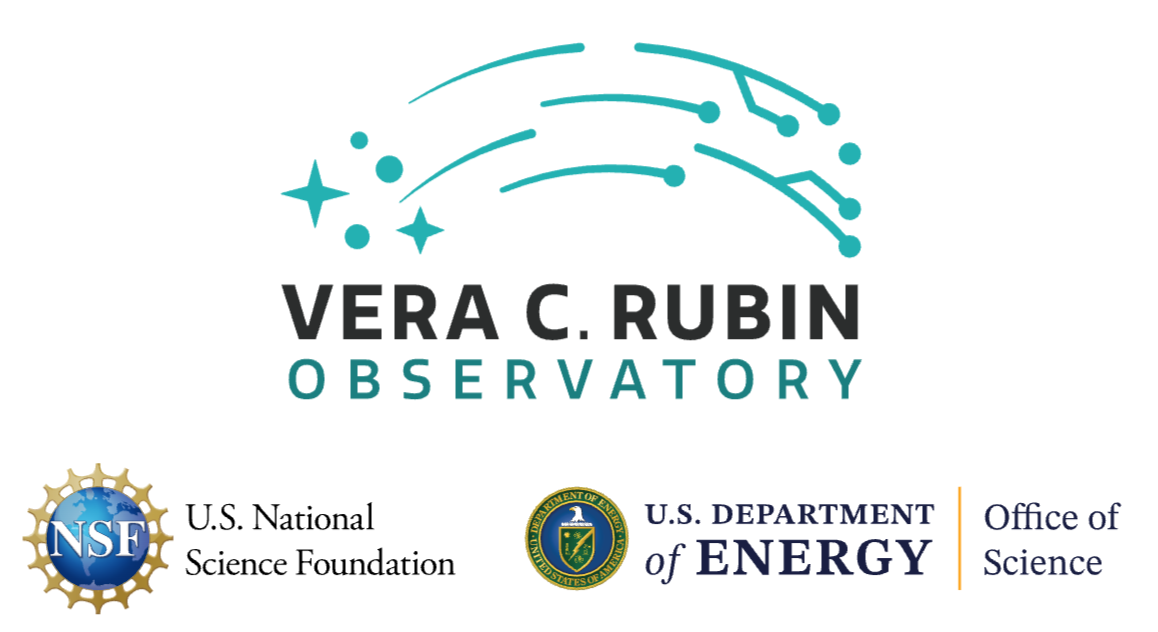

</div>

For the Rubin Science Platform at data.lsst.cloud. <br>
Data Release: <a href="https://dp1.lsst.io/">Data Preview 1</a> <br>
Container Size: large <br>
LSST Science Pipelines version: r29.2.0 <br>
Last verified to run: 2025-09-17 <br>
Repository: <a href="https://github.com/lsst/tutorial-notebooks">github.com/lsst/tutorial-notebooks</a> <br>

**Learning objective:** An overview of the DP1 ComCam data in the "low-latitude field" RubinSV_95_-25.

**LSST data products:** `deep_coadd`, `CcdVisit`, `Visit`, `Object`

**Packages:** `lsst.rsp`, `lsst.daf.butler`, `lsst.afw.display`

**Credit:**
Originally developed by the Rubin Community Science team.
Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks.

**Get Support:**
Everyone is encouraged to ask questions or raise issues in the 
<a href="https://community.lsst.org/c/support">Support Category</a> 
of the Rubin Community Forum.
Rubin staff will respond to all questions posted there.

## 1. Introduction

This notebook examines the Data Preview 1 (DP1) data products in the "RubinSV_95_-25" field, including magnitude limits, visit distribution with time, data quality, and the distributions of stars and galaxies in color-magnitude and color-color diagrams.

The field denoted "RubinSV_95_-25" is sometimes referred to as the "low-latitude field" because it was at the lowest Galactic latitude of any of the fields observed during ComCam on-sky commissioning. RubinSV_95_-25 is centered at (RA, Dec) = (95.0, -25.0) degrees, corresponding to Galactic longitude/latitude of (l, b) = (232.5, -17.6) degrees. It is relatively far from the Galactic plane, and not representative of the crowded fields that LSST will see in the Milky Way disk. Nonetheless, it contains the highest source density of any of the ComCam fields in DP1. The region covered spans a diameter of about 1 degree.

**Related tutorials:** The 100-level tutorials demonstrate how to use the butler, the TAP service, and the Firefly image display. The 200-level tutorials introduce the types of image and catalog data.

### 1.1. Import packages

Import `numpy`, a fundamental package for scientific computing with arrays in Python
(<a href="https://numpy.org">numpy.org</a>), and
`matplotlib`, a comprehensive library for data visualization
(<a href="https://matplotlib.org/">matplotlib.org</a>; 
<a href="https://matplotlib.org/stable/gallery/index.html">matplotlib gallery</a>), including custom shapes (`Polygon`) and lines (`mlines`). `itertools` supports efficient iteration and combinatorics.

From the `lsst` package, import modules for accessing the Table Access Protocol (TAP) service, for retrieving datasets from the butler, and image display functions from the LSST Science Pipelines (<a href="https://pipelines.lsst.io/">pipelines.lsst.io</a>). Additional modules support spherical geometry (`sphgeom`), and standardized multiband plotting (`lsst.utils.plotting`) for LSST data analysis and visualization.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.lines as mlines
import itertools
from astropy.coordinates import SkyCoord
import astropy.units as u

from lsst.rsp import get_tap_service
from lsst.daf.butler import Butler
import lsst.afw.display as afw_display
import lsst.sphgeom as sphgeom
from lsst.utils.plotting import (get_multiband_plot_colors,
                                 get_multiband_plot_symbols,
                                 get_multiband_plot_linestyles)

### 1.2. Define parameters and functions

Create an instance of the TAP service, and assert that it exists.

In [ ]:
service = get_tap_service("tap")
assert service is not None

Create an instance of the butler, and assert that it exists.

In [ ]:
butler = Butler('dp1', collections="LSSTComCam/DP1")
assert butler is not None

Define the approximate central coordinates of the RubinSV_95_-25 field, and a 1-degree radius `region` to use when querying for overlapping images.

In [ ]:
ra_cen = 95.0
dec_cen = -25.0
radius = 1.0
region = sphgeom.Region.from_ivoa_pos(f"CIRCLE {ra_cen} {dec_cen} {radius}")

Define parameters to use colorblind-friendly colors with `matplotlib`.

In [ ]:
plt.style.use('seaborn-v0_8-colorblind')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

Define colors, symbols, and linestyles to represent the six LSST filters, $ugrizy$.

In [ ]:
filter_colors = get_multiband_plot_colors()
filter_symbols = get_multiband_plot_symbols()
filter_linestyles = get_multiband_plot_linestyles()

Set `afwDisplay` to use Firefly to display images, and open Firefly frame 1.

In [ ]:
afw_display.setDefaultBackend('firefly')
display = afw_display.Display(frame=1)

## 2. Coadd sky coverage and depth

The individual LSSTComCam images have been combined (stacked) into `deep_coadd` images, and sky maps of the accumulated exposure time and image depth have been created.

### 2.1. Display a deep coadd

Query the butler for all $r$-band `deep_coadd` images that overlap the defined `region`.

In [ ]:
coadd_datasetrefs = butler.query_datasets("deep_coadd",
                                          where="patch.region OVERLAPS region AND band='r'",
                                          bind={"region": region},
                                          with_dimension_records=True,
                                          order_by=["patch.tract"])

In [ ]:
print('There are %s r-band deep_coadd images.' % len(coadd_datasetrefs))

Retrieve the `deep_coadd` image associated with the last (index "-1") of the dataset references returned by the butler query.

In [ ]:
coadd = butler.get(coadd_datasetrefs[-1])

Display the image, and set the mask plane to be fully transparent.

In [ ]:
display.mtv(coadd)
display.setMaskTransparency(100)

### 2.2. Exposure time and depth

Retrieve the entire survey property map of the $r$-band magnitude limit as `hspmap_rmaglim`, and of the total $r$-band exposure time as `hspmap_rexptime`.

In [ ]:
hspmap_rexptime = butler.get('deepCoadd_exposure_time_consolidated_map_sum',
                             skymap='lsst_cells_v1', band='r')
hspmap_rmaglim = butler.get('deepCoadd_psf_maglim_consolidated_map_weighted_mean',
                            skymap='lsst_cells_v1', band='r')

Extract the healsparse map values in a region within the previously-defined radius of the RubinSV_95_-25 field center and divide the region into a 250x250 grid. Evaluate each survey property map at these grid points. Replace all negative values (no-data placeholders) with NaN ("not a number") to facilitate map display.

In [ ]:
dec_size = radius
ra_size = dec_size / np.cos(np.radians(dec_cen))
ra_min, ra_max = ra_cen - ra_size, ra_cen + ra_size
dec_min, dec_max = dec_cen - dec_size, dec_cen + dec_size

ra = np.linspace(ra_min, ra_max, 250)
dec = np.linspace(dec_min, dec_max, 250)
x, y = np.meshgrid(ra, dec)

values_rmaglim = hspmap_rmaglim.get_values_pos(x, y)
values_rmaglim = np.where(values_rmaglim < 0.0, np.nan, values_rmaglim)

values_rexptime = hspmap_rexptime.get_values_pos(x, y)
values_rexptime = np.where(values_rexptime < 0.0, np.nan, values_rexptime)

Clean up.

In [ ]:
del ra, dec

Print the mean, median, and min/max values for the $r$-band magnitude limit and exposure time. Exposure times are accumulated over multiple visits, not single exposures.

In [ ]:
print('r-band magnitude limit mean/median: %5.2f %5.2f' %
      (np.nanmean(values_rmaglim), np.nanmedian(values_rmaglim)))
print('r-band magnitude min/max: %5.2f %5.2f' %
      (np.nanmin(values_rmaglim), np.nanmax(values_rmaglim)))
print('\n')
print('r-band exposure time (s) mean/median: %5.1f %5.1f' %
      (np.nanmean(values_rexptime), np.nanmedian(values_rexptime)))
print('r-band exposure time min/max (s): %5.1f %5.1f' %
      (np.nanmin(values_rexptime), np.nanmax(values_rexptime)))

### 2.3. Coverage map

Define unique colors and linestyles for plotting each of the tracts in the dataset.

In [ ]:
alltracts = [rec.dataId['tract'] for rec in coadd_datasetrefs]
unique_tracts = np.unique(alltracts)

colors = plt.cm.tab10(np.linspace(0, 1, len(unique_tracts)))
linestyles = ['-', '--', '-.', ':'] * ((len(unique_tracts) // 4) + 1)

style_dict = {tract: {'color': colors[i], 'linestyle': linestyles[i]}
              for i, tract in enumerate(unique_tracts)}

Use TAP to find vertices of each patch covering the field in the `dp1.coaddPatches` table.

In [ ]:
query = "SELECT lsst_patch, lsst_tract, s_ra, s_dec, s_region " \
        "FROM dp1.CoaddPatches " \
        "WHERE CONTAINS(POINT('ICRS', s_ra, s_dec), " \
        "CIRCLE('ICRS', {}, {}, {})) = 1 ".format(ra_cen, dec_cen, radius)
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()

Fetch the results as an `astropy` table.

In [ ]:
assert job.phase == 'COMPLETED'
coadd_patches = job.fetch_result().to_table()

Use `matplotlib.patches.Polygon` along with `ax.add_patch()` to draw each patch outline. Each tract is plotted with a distinct color and linestyle for visual clarity.

For more details on tracts and patches, see the 100-level tutorials on the butler.

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))

mesh = ax.pcolormesh(x, y, values_rmaglim, cmap='Greys_r', shading='auto')
fig.colorbar(mesh, ax=ax, label="r-band limiting magnitude (mag)")

for tract in tracts:
    s_regions = coadd_patches[coadd_patches['lsst_tract'] == tract]['s_region']

    for s_region in s_regions:
        coordinates = np.array(s_region.split()[2:], dtype=float)
        ra = coordinates[0::2]
        ra = (ra + 180) % 360 - 180
        dec = coordinates[1::2]
        vertices_deg = np.vstack([ra, dec]).T

        polygon = Polygon(vertices_deg, closed=True, facecolor='None',
                          edgecolor=style_dict[tract]['color'],
                          linestyle=style_dict[tract]['linestyle'],
                          linewidth=2)
        ax.add_patch(polygon)

ax.set_xlim(ra_max, ra_min)
ax.set_ylim(dec_min, dec_max)
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')

handles = [
    mlines.Line2D([], [], color=style['color'], linestyle=style['linestyle'],
                  label=f"Tract {tract}")
    for tract, style in style_dict.items()
]
ax.legend(handles=handles, loc='upper left', ncol=2)

ax.minorticks_on()
ax.set_title('Tracts and patches that overlap RubinSV_95_-25')

plt.tight_layout()
plt.show()

> **Figure 1:** $r$-band limiting magnitude map for the RubinSV_95_-25 field, shown in greyscale, with values ranging from approximately 23.8 to 26.6 mag. Patch boundaries are overplotted and color-coded by tract, as indicated in the legend.

Clean up.

In [ ]:
del coadd_datasetrefs
del hspmap_rmaglim, hspmap_rexptime
del x, y, values_rmaglim, values_rexptime
del style_dict
del tracts, s_regions, coordinates, ra, dec

## 3. Visits (observations)

Retrieve all visits from the `Visit` table that fall within a circular region centered at (RA, Dec) = (`ra_cen`, `dec_cen`) with a radius of 1 degree. Return the visit ID, band, and observation midpoint time in both MJD and calendar date.

In [ ]:
query = """
        SELECT visit, band, expMidptMJD, expMidpt, expTime
        FROM dp1.Visit
        WHERE CONTAINS(POINT('ICRS', ra, dec),CIRCLE('ICRS', {}, {}, {}))=1
        """.format(ra_cen, dec_cen, radius)

In [ ]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()

In [ ]:
assert job.phase == 'COMPLETED'
visits = job.fetch_result().to_table()
print(f"Total number of visits: {len(visits)}")

Option to display the table of results.

In [ ]:
# visits

### 3.1. Filter distribution

Count and list the number of visits per filter.

In [ ]:
all_bands = np.array([visit['band'] for visit in visits], dtype=str)
unique_bands, counts = np.unique(all_bands, return_counts=True)

for band, count in zip(unique_bands, counts):
    print(band, count)

Clean up.

In [ ]:
del all_bands, unique_bands, counts

### 3.2. Visit dates

Plot two characteristics of the visit dates:
1. the cumulative distribution of visit dates for each of the six bands, $ugrizy$,
2. the distribution of time separations between visits for each band, and for all bands combined.

In [ ]:
t_start = visits[0]['expMidptMJD'] - 1.0
t_end = visits[-1]['expMidptMJD'] + 1.0
time_bins = np.arange(t_end - t_start, dtype='int') + t_start
diff_bins = np.arange(0, np.max(time_bins) - np.min(time_bins) + 3, 1)
all_time_diffs = []

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))

for band in ['u', 'g', 'r', 'i', 'z', 'y']:
    mjds = sorted([
        visit['expMidptMJD']
        for visit in visits
        if str(visit['band']).startswith(band)
    ])
    mjds = np.array(mjds, dtype=float)
    label = f"{band} ({len(mjds)})"

    counts, _, patches = ax1.hist(
        mjds, bins=time_bins, cumulative=True, histtype='step',
        linewidth=2, color=filter_colors[band], label=label
    )
    for patch in patches:
        patch.set_linestyle(filter_linestyles[band])

    tdiffs = []
    for comb in itertools.combinations(mjds, 2):
        tdiffs.append(comb[1] - comb[0])
    time_diffs = np.array(tdiffs)
    all_time_diffs.append(time_diffs)

    counts_diff, _, patches_diff = ax2.hist(
        time_diffs, bins=diff_bins, histtype='step', linewidth=2,
        color=filter_colors[band], label=band
    )
    for patch in patches_diff:
        patch.set_linestyle(filter_linestyles[band])

all_time_diffs = np.concatenate(all_time_diffs)
ax2.hist(
    all_time_diffs, bins=diff_bins, histtype='step', linewidth=2,
    color='black', label='all filters'
)

ax1.legend(loc='upper left')
ax1.set_xlabel('Modified Julian Date')
ax1.set_ylabel('Cumulative number of visits')
ax1.minorticks_on()

ax2.legend(loc='upper right', ncol=2)
ax2.set_yscale('log')
ax2.set_xlabel('separation between observations (d)')
ax2.set_ylabel('number of observations')
ax2.minorticks_on()

plt.suptitle('Visit temporal distributions in RubinSV_95_-25')
plt.show()

> **Figure 2:** The left panel shows the cumulative number of visits in the $ugrizy$ bands as a function of time. This plot shows that $riy$-band images were prioritized in the early nights of observing, with all of the $y$-band observations obtained on the first night. Observations in $u$-band happened only between MJD of 60644-60647, while $griz$ bands continued to accumulate througout the observing campaign.
>
> The right panel shows histograms of the visit-to-visit time separations between observations for each filter individually, along with a black histogram representing the aggregate distribution for all filters combined. There are over 3000 observations with intra-night cadences (i.e., separations less than 1 day), and a decreasing number to longer timespans out to a maximum time difference of 23 days (about 35 observations).

Clean up.

In [ ]:
del time_bins, all_time_diffs

### 3.3. Visit image quality

Statistics about the image quality and the observations can be extracted from the `CcdVisit` table.

In [ ]:
query = """
        SELECT visitId, ra, dec, band, seeing, magLim
        FROM dp1.CcdVisit
        WHERE CONTAINS(POINT('ICRS', ra, dec),CIRCLE('ICRS', {}, {}, {}))=1
        """.format(ra_cen, dec_cen, radius)

In [ ]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()

In [ ]:
assert job.phase == 'COMPLETED'
ccd_visits = job.fetch_result().to_table()

Plot the distribution of `seeing`, which is the mean full width at half maximum of the PSF, for all visit and detector combinations.

In [ ]:
seeing_bins = np.arange(0.5, 2.6, 0.05)

fig = plt.figure(figsize=(7, 5))
for band in ['u', 'g', 'r', 'i', 'z', 'y']:
    print(f"Median in {band}-band: \
            {np.nanmedian(ccd_visits[ccd_visits['band'] == band]['seeing'].compressed()): .2f}")
    n, bins, patches = plt.hist(ccd_visits[ccd_visits['band'] == band]['seeing'].compressed(),
                                seeing_bins, histtype='step',
                                linewidth=2,
                                color=filter_colors[band],
                                label=band)
    for patch in patches:
        patch.set_linestyle(filter_linestyles[band])

plt.legend(loc='upper right')
plt.xlabel('PSF FWHM (arcsec)')
plt.ylabel('number of visits')
plt.title('Per-detector image quality in the RubinSV_95_-25 field')
plt.minorticks_on()
plt.show()

> **Figure 3:** Histogram of delivered image quality of detector images, separated by the six $ugrizy$ bands. The majority of observations have delivered PSF size between 0.7 to 1.5 arcseconds, with the most frequently observed $r$- and $g$-bands peaking at about 1.15 and 1.25 arcseconds, respectively.

Clean up.

In [ ]:
del seeing_bins

Plot the distribution of the magnitude limit, `magLim`.

In [ ]:
min_mag, max_mag = np.min(ccd_visits['magLim']), np.max(ccd_visits['magLim'])
maglim_bins = np.arange(min_mag, max_mag, 0.1)

fig = plt.figure(figsize=(7, 5))

for band in ['u', 'g', 'r', 'i', 'z', 'y']:
    print(f"Median in {band}-band: \
            {np.nanmedian(ccd_visits[ccd_visits['band'] == band]['magLim'].compressed()): .2f}")
    n, bins, patches = plt.hist(ccd_visits[ccd_visits['band'] == band]['magLim'].compressed(),
                                maglim_bins, histtype='step',
                                linewidth=2,
                                color=filter_colors[band],
                                label=band)
    for patch in patches:
        patch.set_linestyle(filter_linestyles[band])

plt.legend(loc='upper left')
plt.xlabel('limiting magnitude')
plt.ylabel('number of visits')
plt.title('Per-detector limiting magnitudes in the RubinSV_95_-25 field')
plt.minorticks_on()
plt.show()

> **Figure 4:** Histogram of limiting magnitude at signal-to-noise=5 on detector images, separated by the six $ugrizy$ bands. The width of the distribution in each band is typically less than one magnitude. The deepest images are in the $r$- and $g$-bands, reaching typical limiting magnitudes of roughly 24.5 mag.

Clean up.

In [ ]:
del maglim_bins

## 4. Objects (detections)

The `Object` table contains forced measurements on the deep coadded images at the locations of all objects detected with signal-to-noise ratio > 5 in a `deep_coadd` of any filter.

Query the `Object` table for objects in the field, and return their coordinates, the value of E(B-V) at their location, and their PSF and `cModel` AB magnitudes.

In [ ]:
query = """
        SELECT objectId, coord_ra, coord_dec,
               u_psfMag, u_cModelMag, g_psfMag, g_cModelMag,
               r_psfMag, r_cModelMag, i_psfMag, i_cModelMag,
               z_psfMag, z_cModelMag, y_psfMag, y_cModelMag,
               refExtendedness
        FROM dp1.Object
        WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec),
              CIRCLE('ICRS', {}, {}, {})) = 1
        """.format(ra_cen, dec_cen, radius)

In [ ]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()

In [ ]:
assert job.phase == 'COMPLETED'
objtab = job.fetch_result().to_table()

### 4.1. Magnitude distribution

Plot histograms of object magnitudes, separating the samples into stars and galaxies. 

Use the `refExtendedness` flag to distinguish them: treat objects with `refExtendedness == 1` as likely galaxies (extended) and those with `refExtendedness == 0` as likely stars (point sources).

Use `cModelMag` mags for galaxies and `psfMag` for stars.

In [ ]:
ptsource = (objtab['refExtendedness'] == 0)

In [ ]:
mag_bins = np.arange(15.4, 28.6, 0.2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
plt.subplots_adjust(hspace=0, wspace=0)

for band in ['u', 'g', 'r', 'i', 'z', 'y']:
    mag_psf = objtab[f"{band}_psfMag"]
    mag_cmodel = objtab[f"{band}_cModelMag"]

    valid_mags = (5 < mag_psf) & (mag_psf < 35) &\
                 (5 < mag_cmodel) & (mag_cmodel < 35)

    print(f"Number of objects in {band}-band: {np.sum(valid_mags)}")

    n, bins, patches = ax1.hist(mag_psf[valid_mags & ptsource],
                                bins=mag_bins,
                                histtype='step',
                                linewidth=2,
                                color=filter_colors[band],
                                label=band)
    for patch in patches:
        patch.set_linestyle(filter_linestyles[band])

    n2, bins2, patches2 = ax2.hist(mag_cmodel[valid_mags & ~ptsource],
                                   bins=mag_bins,
                                   histtype='step',
                                   linewidth=2,
                                   color=filter_colors[band],
                                   label=band)
    for patch in patches2:
        patch.set_linestyle(filter_linestyles[band])

ax1.set_xlim(mag_bins.min(), mag_bins.max())
ax1.set_yscale('log')
ax1.set_xlabel('Magnitude')
ax1.set_ylabel('Number of objects')
ax1.set_title('Point sources (PSF mags)')
ax1.legend(loc='upper left', ncols=2)
ax1.minorticks_on()

ax2.set_xlim(mag_bins.min(), mag_bins.max())
ax2.set_xlabel('Magnitude')
ax2.set_title('Extended sources (cModel mags)')
ax2.legend(loc='upper left', ncols=2)
ax2.minorticks_on()

plt.show()

> **Figure 5:** Histogram of object magnitudes separated by morphological type. The left panel shows likely stars (`refExtendedness` == 0) using `PSF` magnitudes, while the right panel shows likely galaxies using `cModel` magnitudes.

Clean up.

In [ ]:
del mag_bins, mag_psf, mag_cmodel, valid_mags

## 5. Analysis

### 5.1. Plot CMDs and CCDs

Plot $r$ vs. $(g-r$) color-magnitude diagrams (CMDs), and $(r-i)$ vs. $(g-r)$ color-color diagrams (CCDs). Create separate diagrams for "stars" and "galaxies", using PSF magnitudes for stars and cModel magnitudes for galaxies.

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7, 6),
                                             height_ratios=[1, 2.5])
plt.subplots_adjust(hspace=0, wspace=0)

grmin, grmax = -0.9, 2.3
rimin, rimax = -1.3, 2.8
magmin, magmax = 15.8, 26.8

ax1.hexbin(objtab[ptsource]['g_psfMag']-objtab[ptsource]['r_psfMag'],
           objtab[ptsource]['r_psfMag']-objtab[ptsource]['i_psfMag'],
           gridsize=(150, 150),
           extent=(grmin, grmax, rimin, rimax), bins='log', cmap='Grays')
ax1.set_title('Point sources (PSF mags)')
ax1.set_xlim(grmin, grmax)
ax1.set_ylim(rimin, rimax)
ax1.set_ylabel(r'$(r-i)$')
ax1.set_xticklabels([])
ax1.minorticks_on()

ax2.hexbin(objtab[~ptsource]['g_cModelMag']-objtab[~ptsource]['r_cModelMag'],
           objtab[~ptsource]['r_cModelMag']-objtab[~ptsource]['i_cModelMag'],
           gridsize=(150, 150),
           extent=(grmin, grmax, rimin, rimax), bins='log', cmap='Grays')
ax2.set_title('Extended sources (cModel mags)')
ax2.set_xlim(grmin, grmax)
ax2.set_ylim(rimin, rimax)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.minorticks_on()

ax3.hexbin(objtab[ptsource]['g_psfMag']-objtab[ptsource]['r_psfMag'],
           objtab[ptsource]['r_psfMag'], gridsize=(150, 200),
           extent=(grmin, grmax, magmin, magmax), bins='log', cmap='Grays')
ax3.plot([0.1, 0.1, 0.6, 0.6, 0.1], [22, 19.5, 19.5, 22, 22], color='Red')
ax3.set_xlim(grmin, grmax)
ax3.set_ylim(magmax, magmin)
ax3.set_xlabel(r'$(g-r)$')
ax3.set_ylabel(r'$r$ magnitude')
ax3.minorticks_on()

ax4.hexbin(objtab[~ptsource]['g_cModelMag']-objtab[~ptsource]['r_cModelMag'],
           objtab[~ptsource]['r_cModelMag'], gridsize=(150, 200),
           extent=(grmin, grmax, magmin, magmax), bins='log', cmap='Grays')
ax4.set_xlim(grmin, grmax)
ax4.set_ylim(magmax, magmin)
ax4.set_xlabel(r'$(g-r)$')
ax4.set_yticklabels([])
ax4.minorticks_on()

plt.show()

> **Figure 6:** Color-magnitude (bottom) and color-color (top) diagrams for objects classified by morphology. The left column shows likely stars using `PSF` magnitudes, and the right column shows likely galaxies using `cModel` magnitudes. The red box is referenced in Section 5.2.

### 5.2. CMD feature

In Figure 6, a red box is drawn around a feature in the CMD of stars at 20<r<22, 0.2<(g-r)<0.6, but what is it?

Use an Astropy `SkyCoord` object for the low-latitude field to estimate its Galactic coordinates.

In [ ]:
sc_lowlat_field = SkyCoord(ra=ra_cen*u.deg, dec=dec_cen*u.deg)
sc_lowlat_field.galactic

It may be part of the Milky Way stellar structure known as the "Monoceros Ring". The red box below represents roughly the Galactic coordinates of Rubin SV 95 -25 overlaid on a figure mapping stellar density in the outer Milky Way from [Slater et al. 2014](https://ui.adsabs.harvard.edu/abs/2014ApJ...791....9S/abstract).

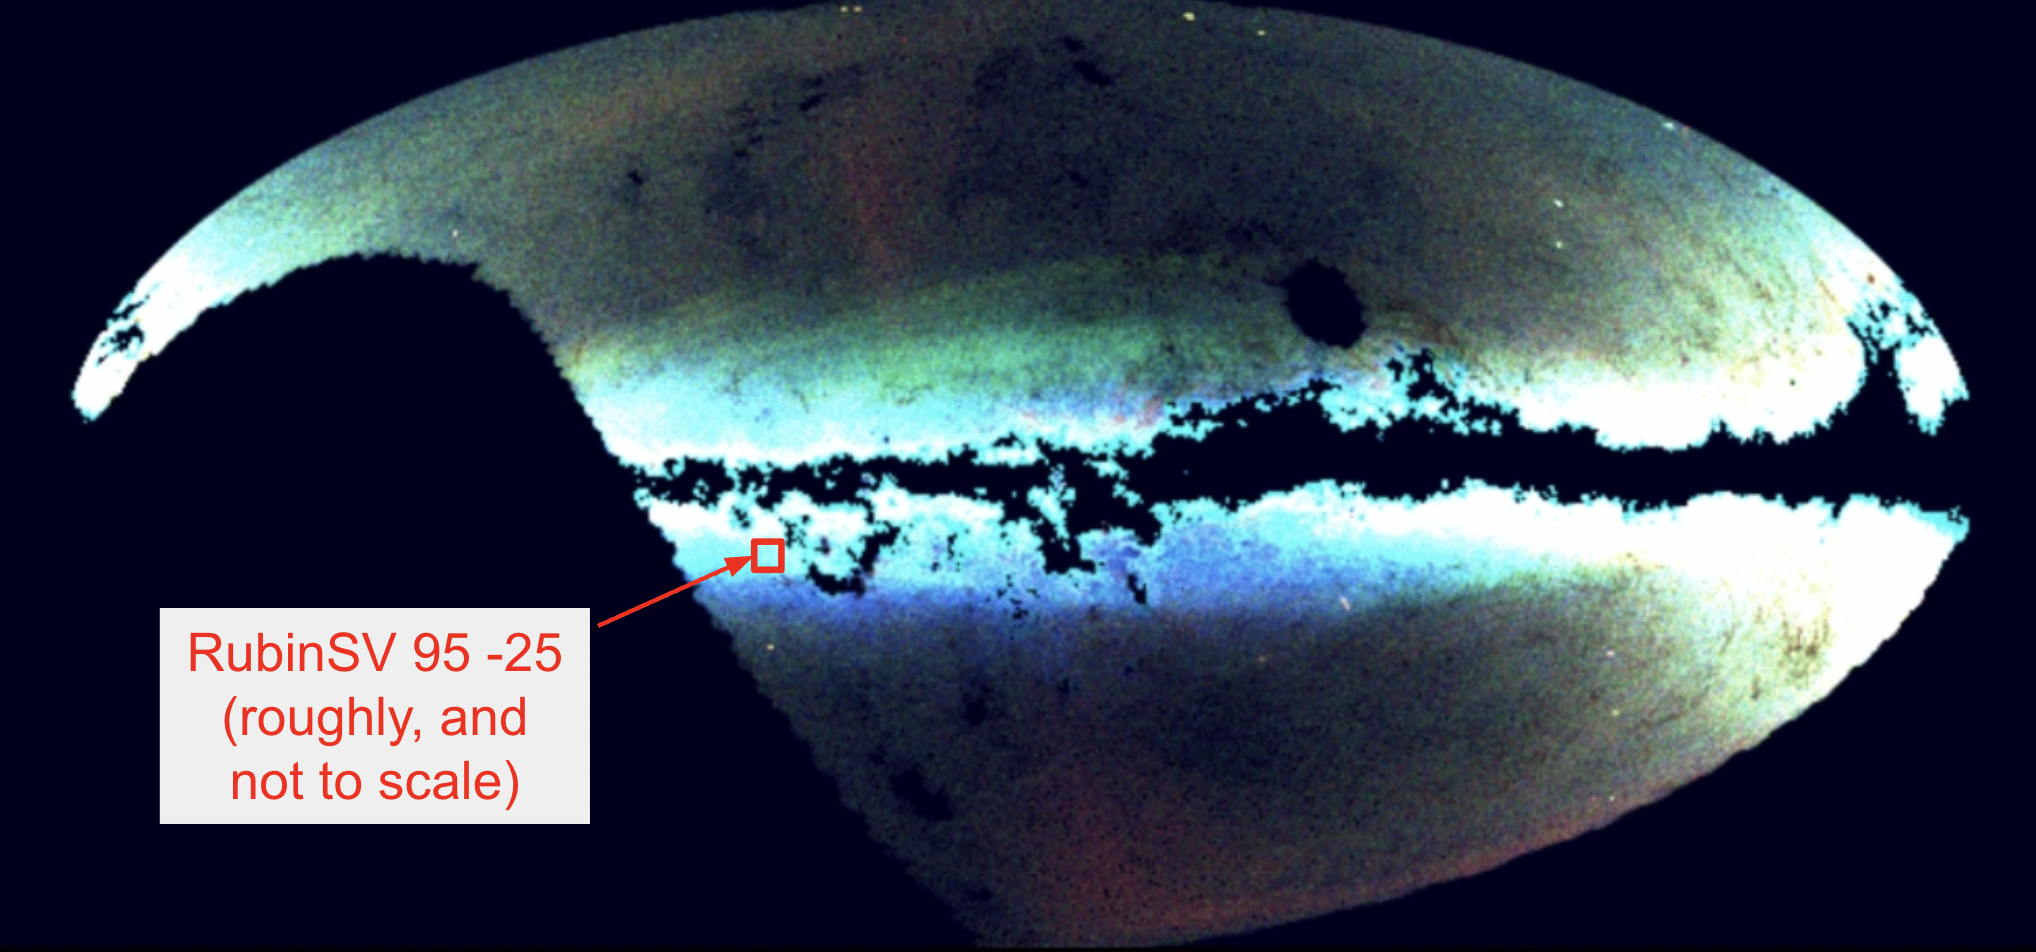